# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import mf_emulator
import data_MPGADGET
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [21]:
# read P1D measurement
#data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.7)
data=data_MPGADGET.P1D_MPGADGET(filename="1024_L90_mimic.json",z_list=[2.0,3.0,4.0])
zs=data.z

In [3]:
#basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
basedir='../../p1d_emulator/sim_suites/emulator_256_15072019/'
kmax_Mpc=4.0
p1d_label=None
skewers_label='Ns256_wM0.05'
keep_every_other_rescaling=True
undersample_z=1
max_arxiv_size=2000
paramList=["Delta2_p","n_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='polyfit'
#emu_type='mf'
if emu_type=='polyfit':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,keep_every_other_rescaling=keep_every_other_rescaling,
                                max_arxiv_size=max_arxiv_size,emu_type=emu_type,
                                kmax_Mpc=kmax_Mpc,verbose=False,paramList=paramList,train=True)
elif emu_type=='k_bin':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                               undersample_z=undersample_z,keep_every_other_rescaling=keep_every_other_rescaling,
                               max_arxiv_size=max_arxiv_size,
                               verbose=False,paramList=paramList,train=True,emu_type=emu_type)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,keep_every_other_rescaling=keep_every_other_rescaling,
                                max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,keep_every_other_rescaling=keep_every_other_rescaling,
                                max_arxiv_size=max_arxiv_size,verbose=False)
elif emu_type=='mf':
    emu=mf_emulator.MeanFluxEmulator(basedir,p1d_label,skewers_label,
                                keep_every_other_rescaling=keep_every_other_rescaling,
                                kmax_Mpc=kmax_Mpc,emu_type='polyfit',max_arxiv_size=None,
                                verbose=True,paramList=paramList,train=True)
else:
    raise ValueError('wrong emulator type '+emu_type)

keep tau scales [0.5 1.  2. ]
keep T0 scales [0.8 1.2]
keep gamma scales [0.9 1.1]
Rescaled params to unity volume
Cannot load emulators with non-standard training data


 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1800 points
Optimised


In [19]:
#theory=lya_theory.LyaTheory(zs,emulator=emu)
theory=lya_theory.get_mock_theory(zs,emulator=emu,alternative_pressure=True)

Note: redshifts have been re-sorted (earliest first)


In [22]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_gamma_0','ln_kF_0']
#free_parameters=['ln_tau_0','T0_1','T0_2','T0_3']
free_parameters=['ln_tau_0','ln_tau_1','ln_gamma_0','ln_kF_0','T0_1','T0_2','T0_3']
min_kp_kms=0.003
prior_Gauss_rms=0.02
# ignore emulator covariance for now
ignore_emu_cov=True
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,
                           min_kp_kms=min_kp_kms,ignore_emu_cov=ignore_emu_cov,
                           prior_Gauss_rms=prior_Gauss_rms,verbose=True)

likelihood setup with 7 free parameters
7 free parameters


In [23]:
for p in like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -1.03436530241446 -1.5 -0.5
ln_tau_1 3.6744666006830182 2.5 3.8
T0_1 0.13626544653787526 0 1
T0_2 9.546039892898634 7 11
T0_3 -1.2041429220366868 -1.5 -0.5
ln_gamma_0 0.3295042060454974 0.09531017980432493 0.6931471805599453
ln_kF_0 -1.3862943611198906 -2.995732273553991 -0.6931471805599453


In [24]:
Np=len(like.free_params)
sampler = emcee_sampler.EmceeSampler(like=like,verbose=True,nwalkers=2*Np+6)

use input likelihood
setup with 20 walkers
set 20 walkers with 7 dimensions
done setting up sampler


### Run burn-in chains

In [25]:
sampler.like.go_silent()

In [26]:
sampler.run_burn_in(nsteps=400+100*Np)

start burn-in, will do 1100 steps
0 [0.46269431 0.90438048 0.13865125 0.63794298 0.29393003 0.38700336
 0.69618355]
20 [0.44701545 0.89796434 0.1425474  0.6118447  0.28958024 0.39511896
 0.6931271 ]
40 [0.43068279 0.88220481 0.14192728 0.63408616 0.29167927 0.40153235
 0.69105309]
60 [0.41218262 0.87041631 0.12968459 0.66245715 0.2963622  0.4021392
 0.68695714]
80 [0.39674042 0.86979268 0.11783791 0.68580727 0.29386743 0.39577002
 0.6869883 ]
100 [0.39237472 0.87316035 0.1159014  0.68983463 0.2866467  0.40672238
 0.6856836 ]
120 [0.38730667 0.87495247 0.11938786 0.69500146 0.28316791 0.40973175
 0.68725893]
140 [0.38452093 0.87576316 0.11484326 0.6980312  0.28724911 0.41536407
 0.6882856 ]
160 [0.38608675 0.8757376  0.11757446 0.6990974  0.29678097 0.41149672
 0.6874038 ]
180 [0.38075401 0.88315995 0.11877952 0.70318424 0.29851553 0.41196057
 0.69002983]
200 [0.38050932 0.87976    0.12019317 0.70517808 0.2991898  0.41189391
 0.68921817]
220 [0.38298845 0.88679459 0.11448393 0.70100906 

### Run main chains

In [27]:
sampler.run_chains(nsteps=1000+300*Np)

0 [0.37522581 0.88499298 0.12255123 0.70955993 0.29155163 0.41777276
 0.68830416]
20 [0.37404041 0.8798377  0.12041313 0.71152994 0.29000238 0.41870665
 0.68793129]
40 [0.37286543 0.87901796 0.12046207 0.70835758 0.29321304 0.42140965
 0.68914675]
60 [0.37288832 0.87687447 0.12292316 0.70976558 0.2895801  0.41927761
 0.68847022]
80 [0.37326927 0.8770086  0.1207799  0.70871939 0.28818865 0.41639458
 0.68949033]
100 [0.37465004 0.87977061 0.12330962 0.7077814  0.29532073 0.41929815
 0.68910252]
120 [0.37700929 0.87864271 0.11999982 0.70575233 0.29384224 0.41720736
 0.68901637]
140 [0.37008036 0.87991948 0.11550405 0.70895089 0.2950228  0.42626305
 0.68890706]
160 [0.37322203 0.88544467 0.12356319 0.7066685  0.29871619 0.4247882
 0.68866428]
180 [0.3724894  0.87751787 0.12754565 0.71118338 0.29978025 0.42070588
 0.68884865]
200 [0.37144256 0.87465145 0.12920944 0.71420822 0.29941579 0.42509943
 0.68723655]
220 [0.37224222 0.86853427 0.12330262 0.71486033 0.29196284 0.41971983
 0.68618078]

In [39]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.482


### Plot results in cube units (0 < x < 1)

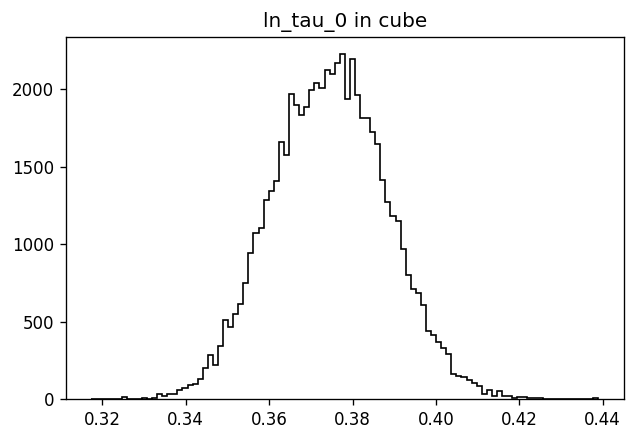

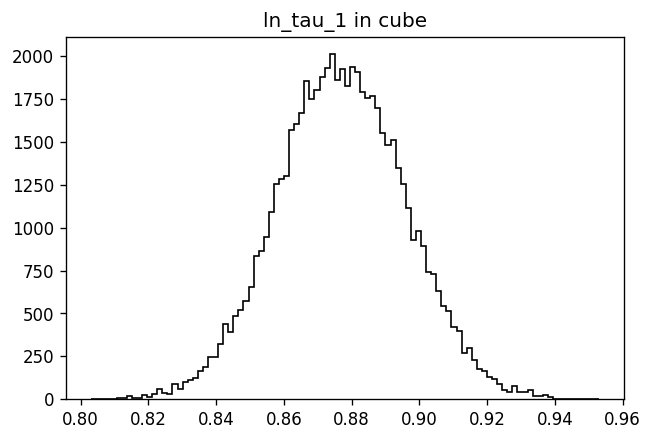

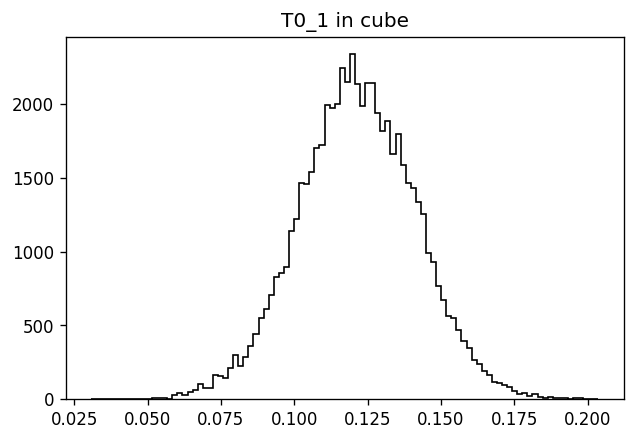

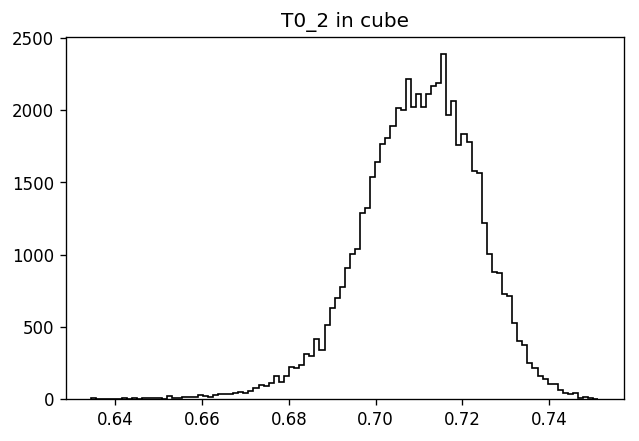

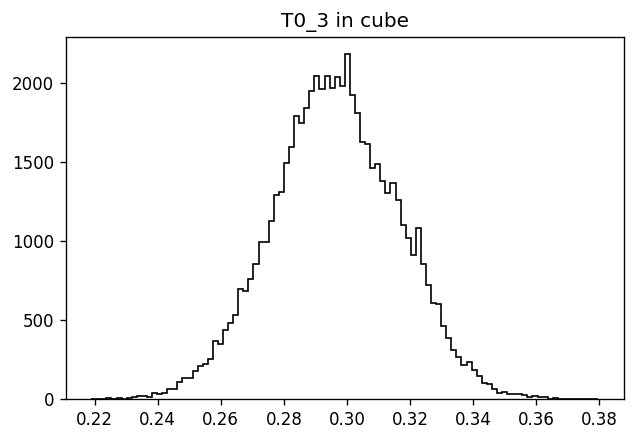

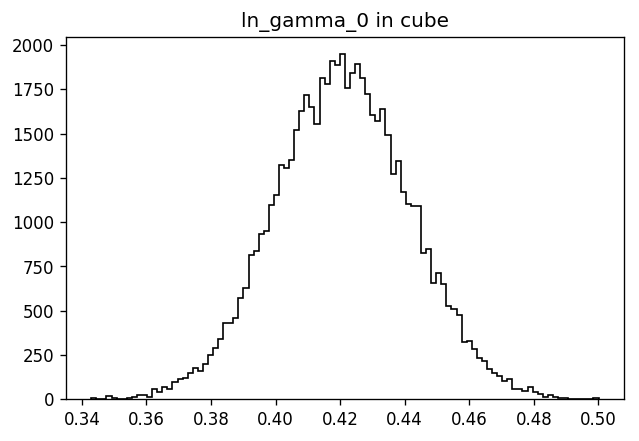

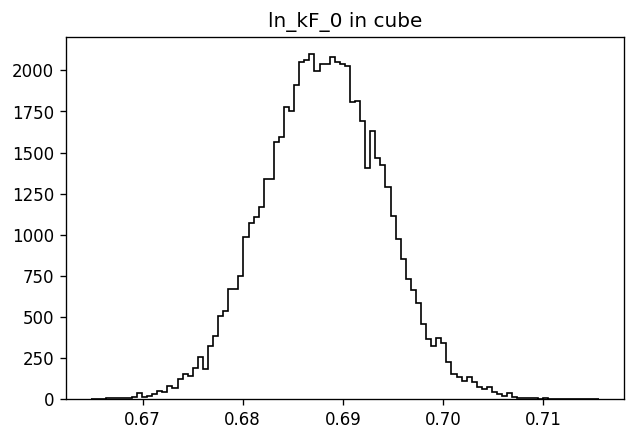

In [40]:
sampler.plot_histograms(cube=True)

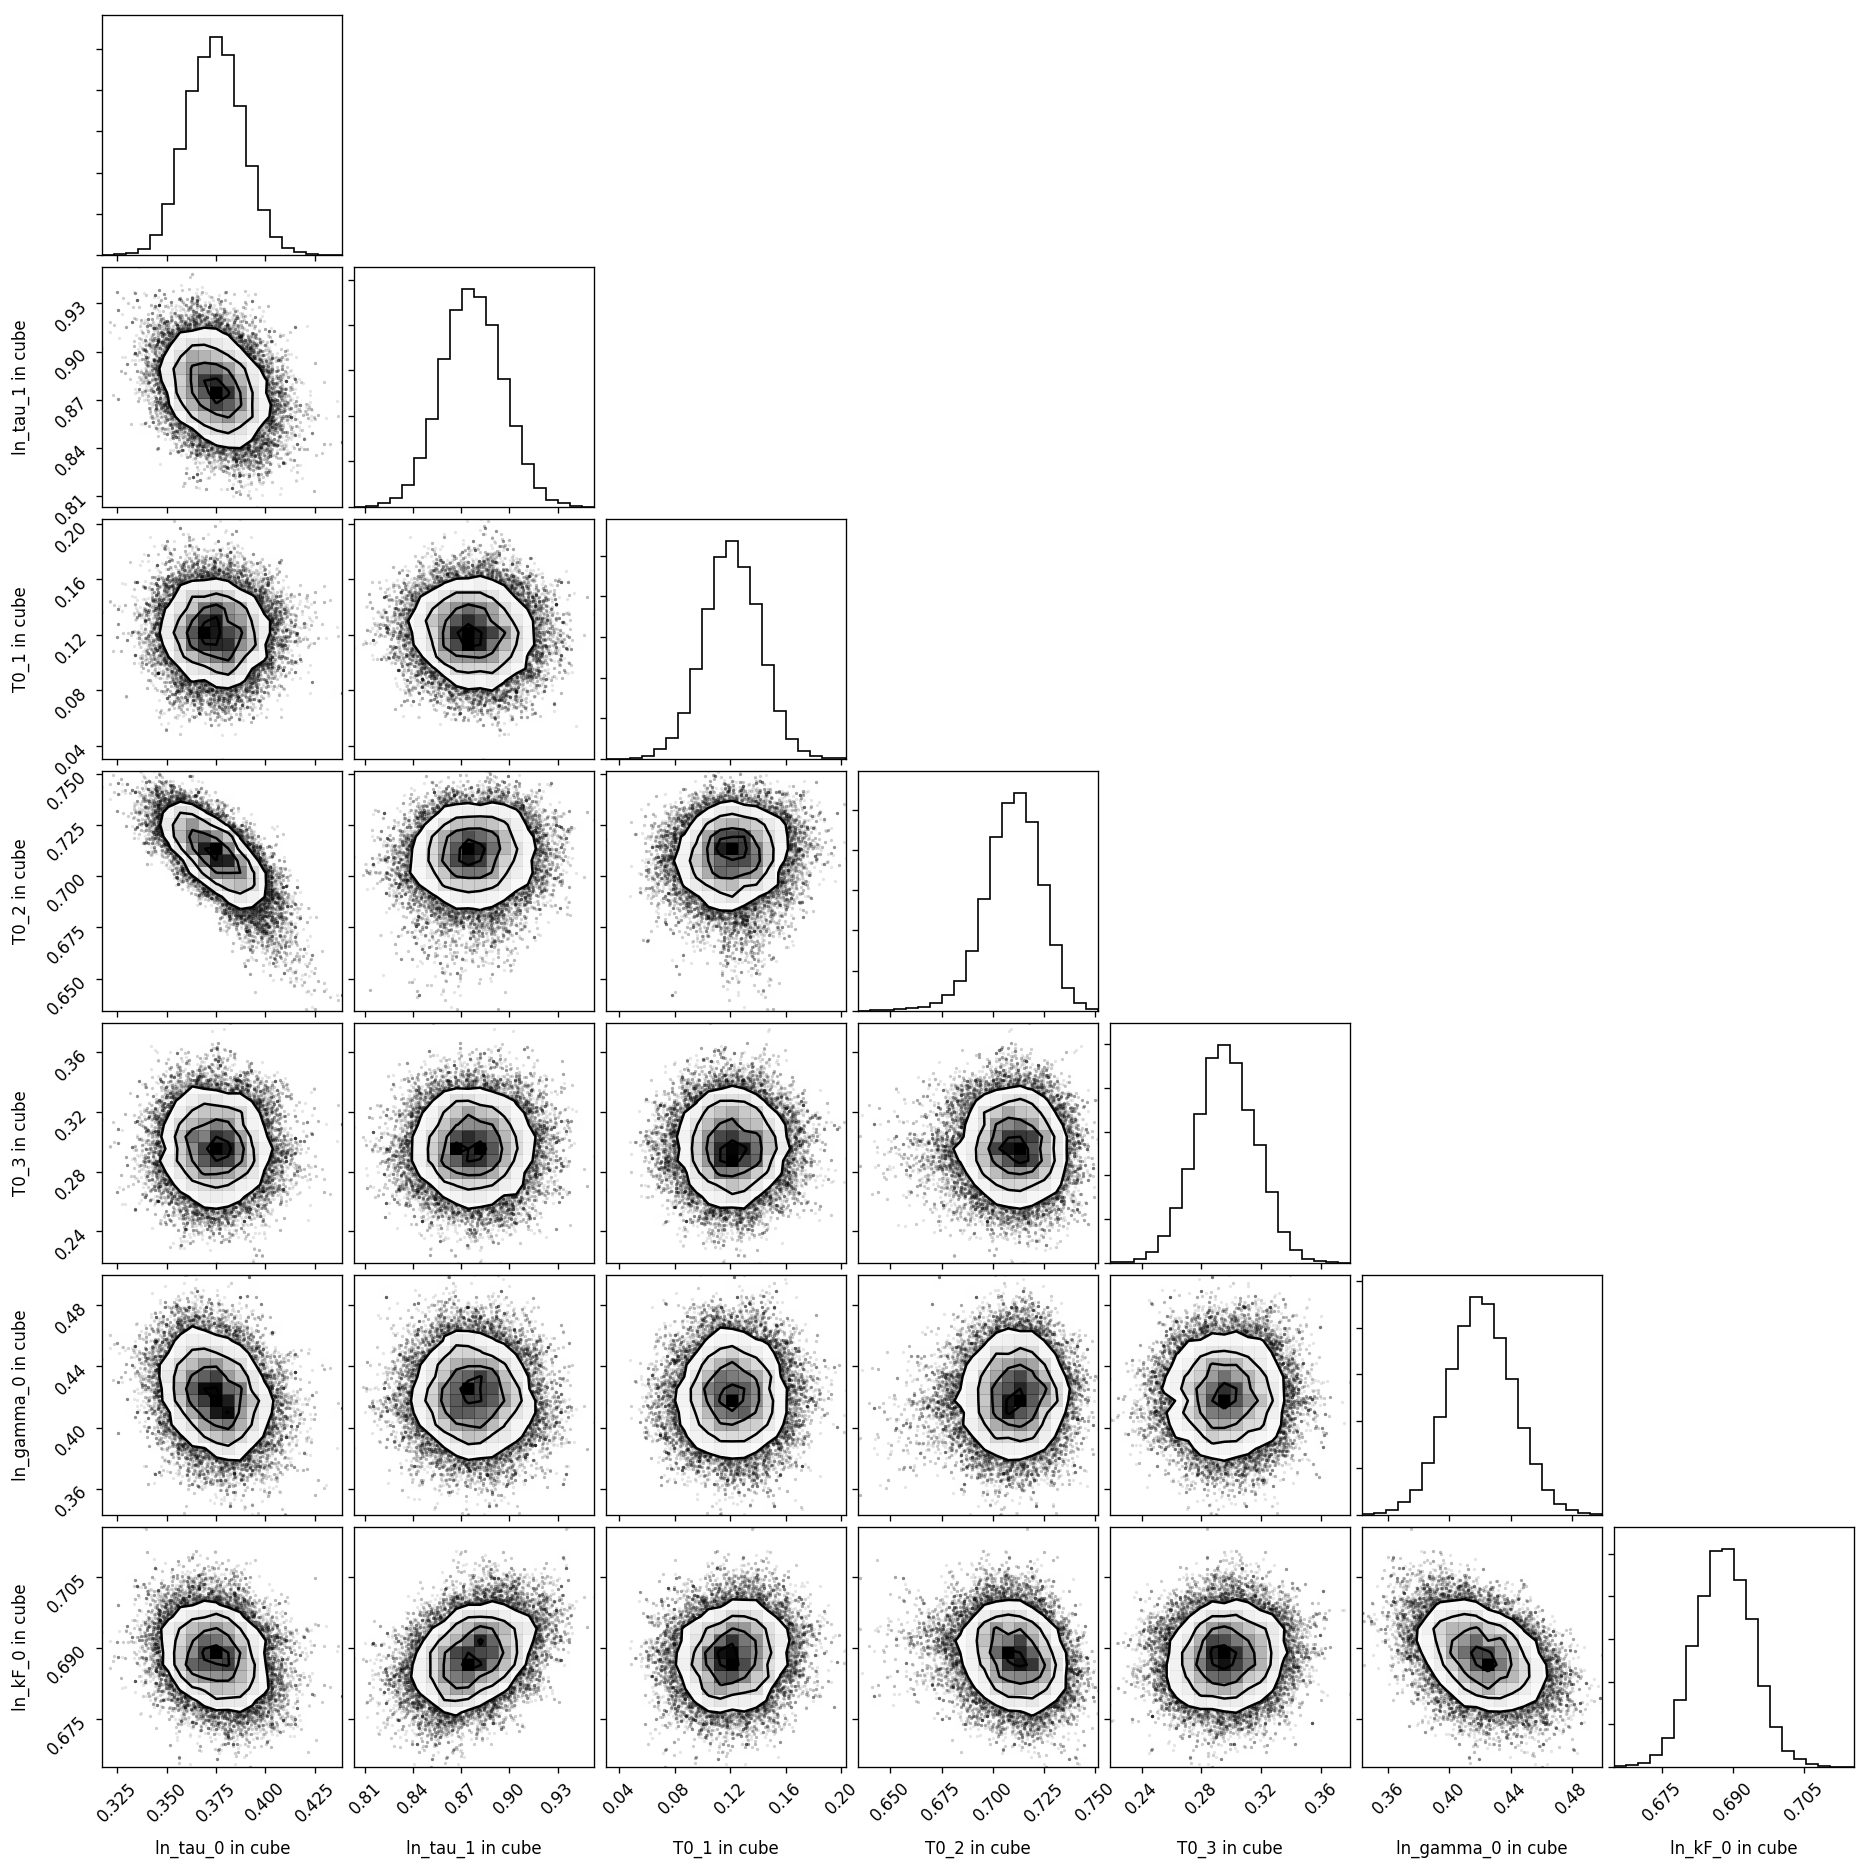

In [41]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

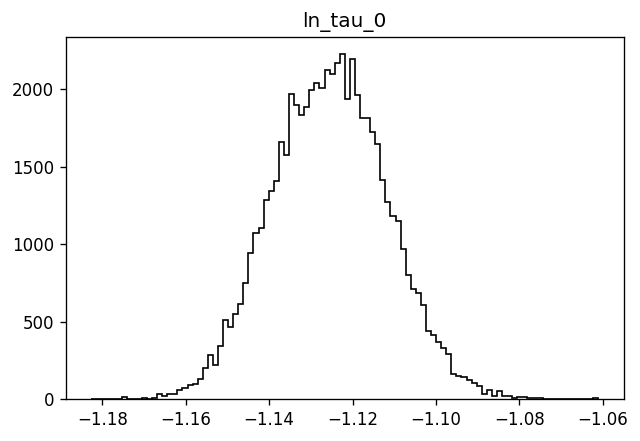

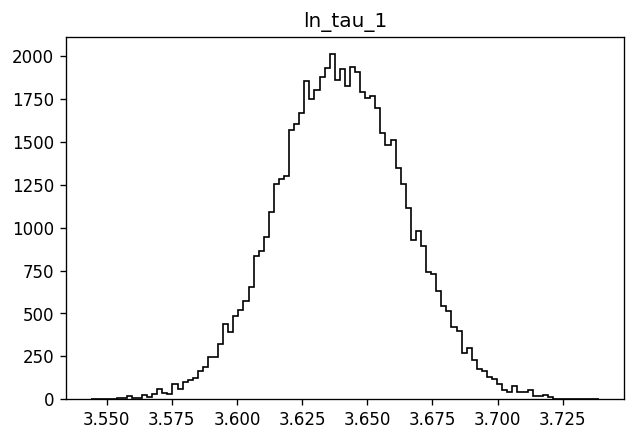

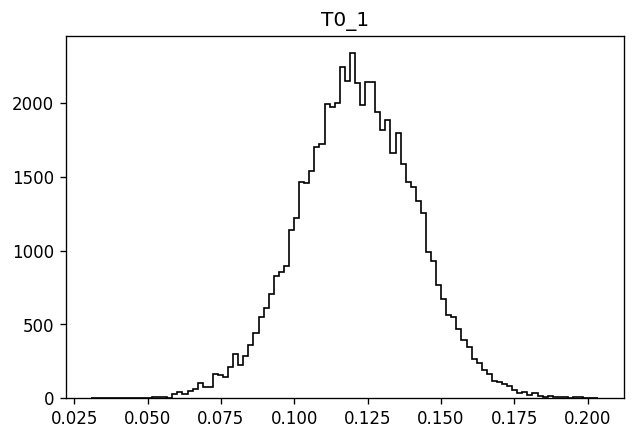

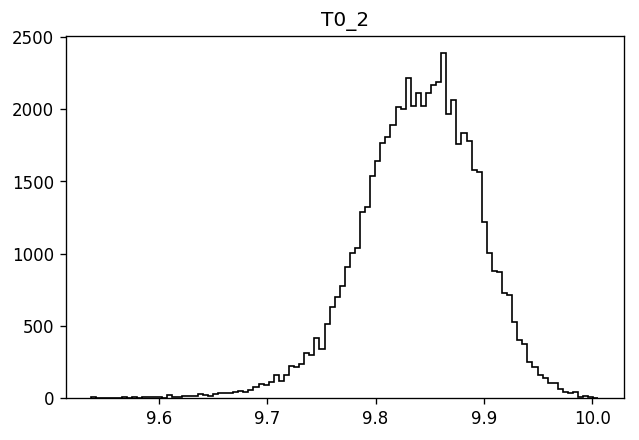

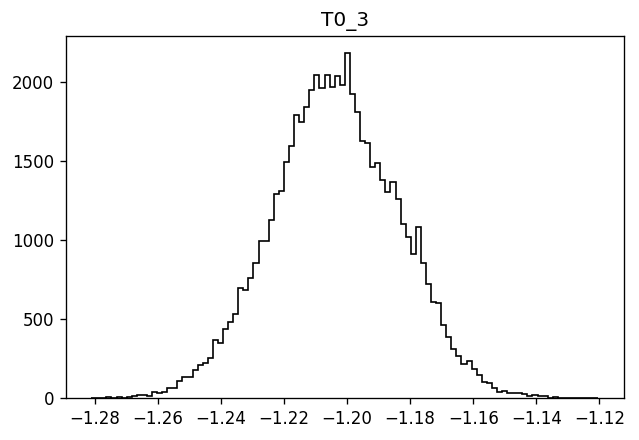

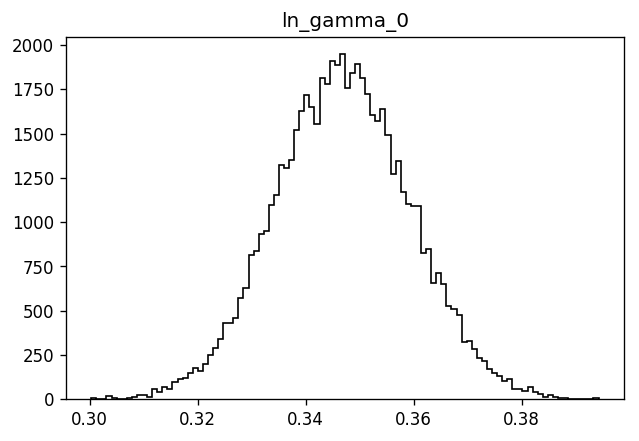

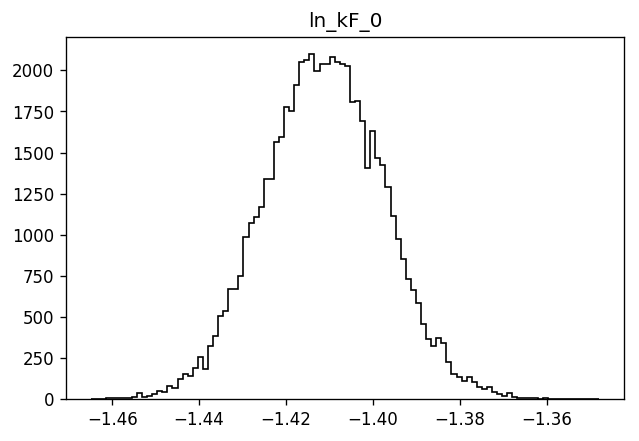

In [42]:
sampler.plot_histograms(cube=False)

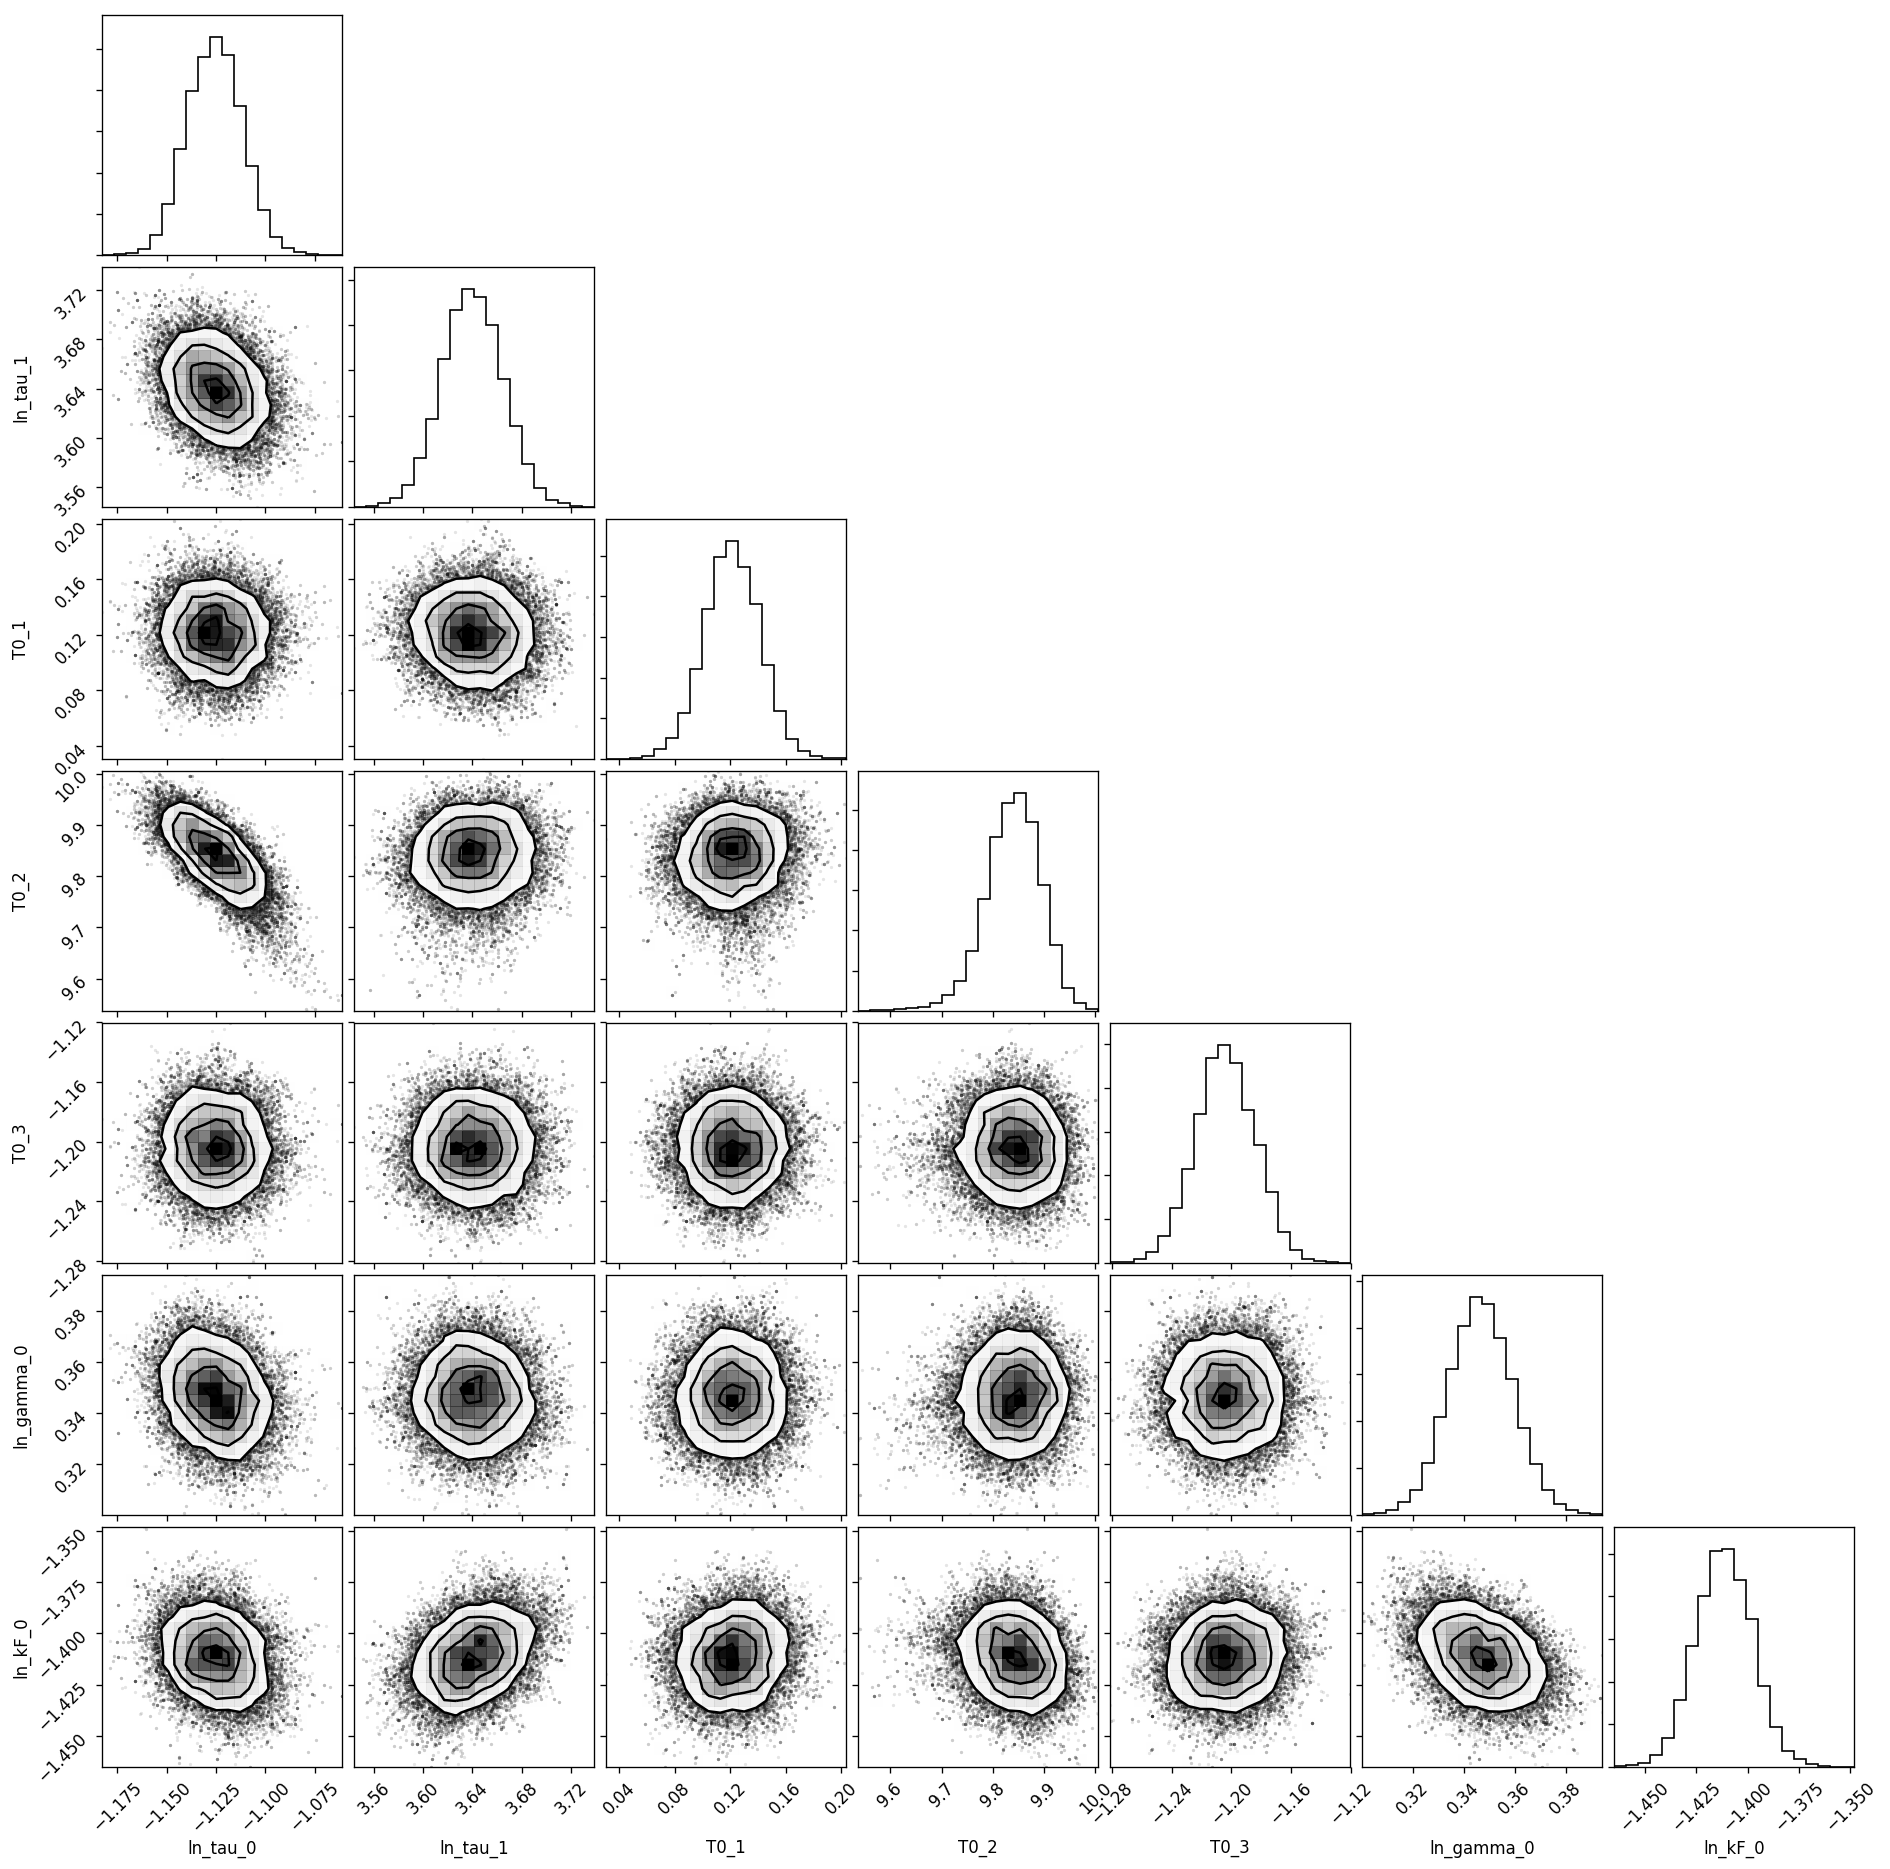

In [43]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [52]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

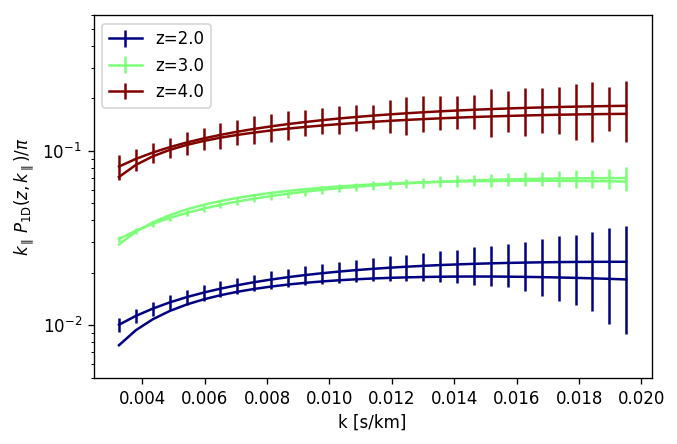

In [53]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=1)

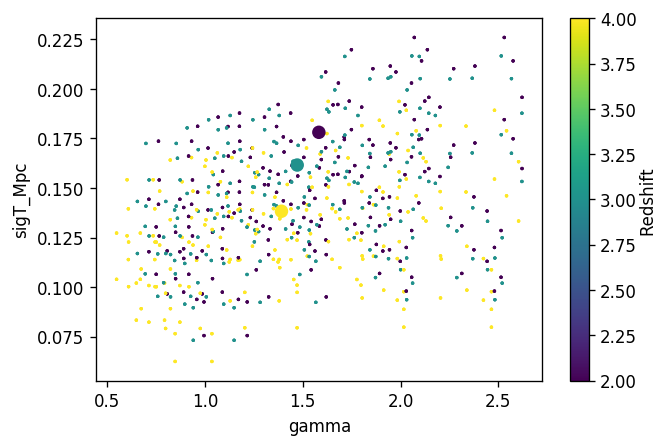

In [56]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=best_fit,tau_scalings=True, temp_scalings=True)

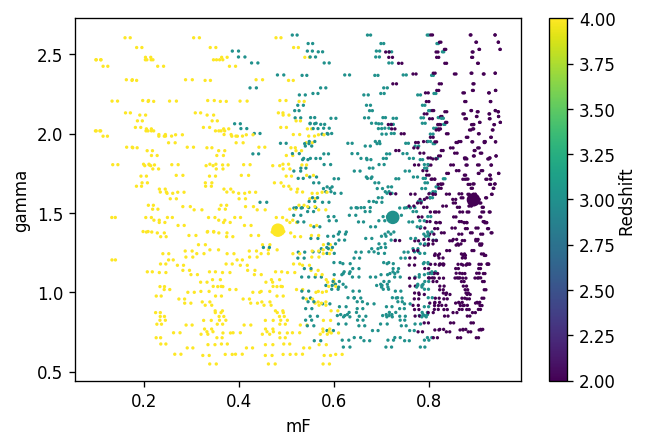

In [57]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit,tau_scalings=True, temp_scalings=True)

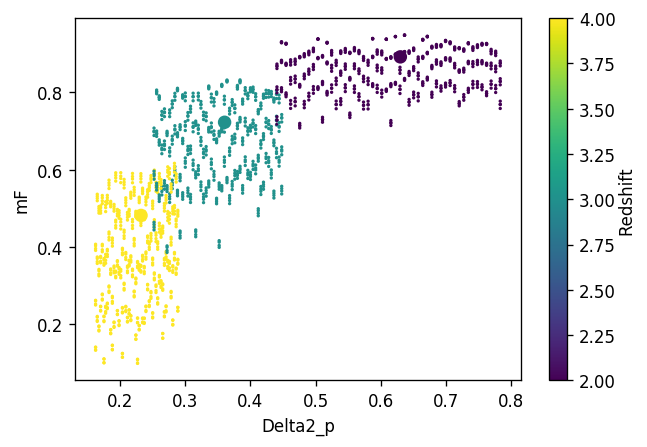

In [58]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=best_fit)

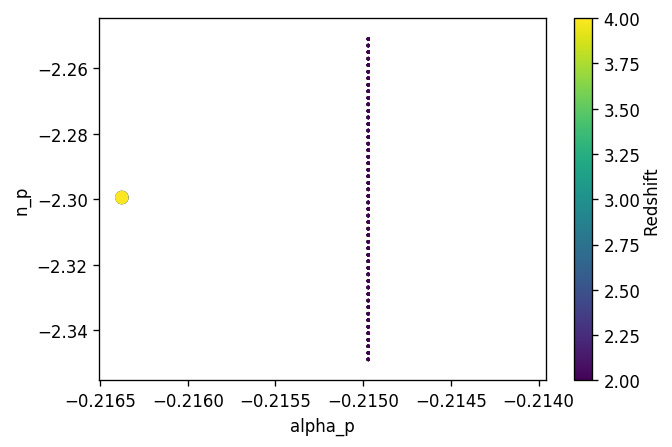

In [59]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=best_fit)

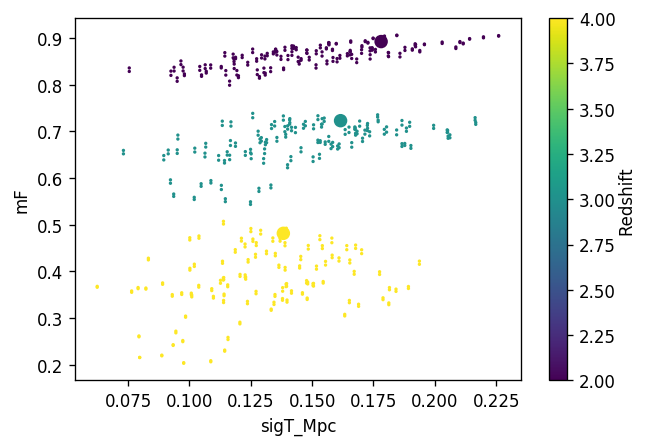

In [63]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=best_fit,tau_scalings=False,temp_scalings=True)

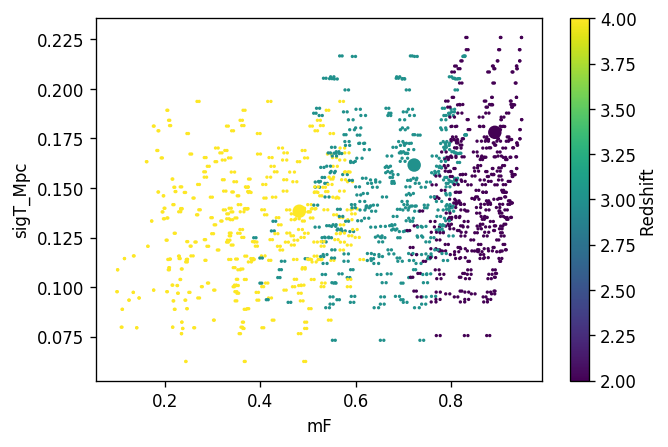

In [64]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=best_fit)

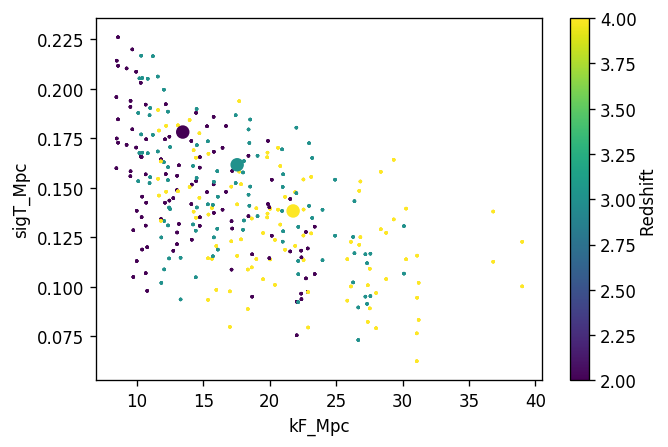

In [65]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=best_fit)

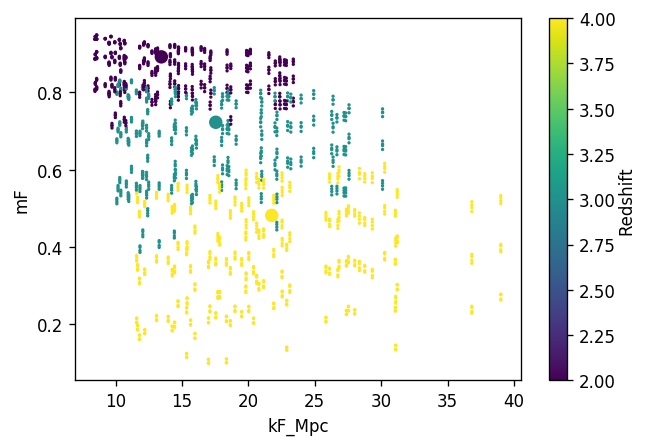

In [66]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=best_fit)

### Write chain to file for later use

In [67]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [68]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


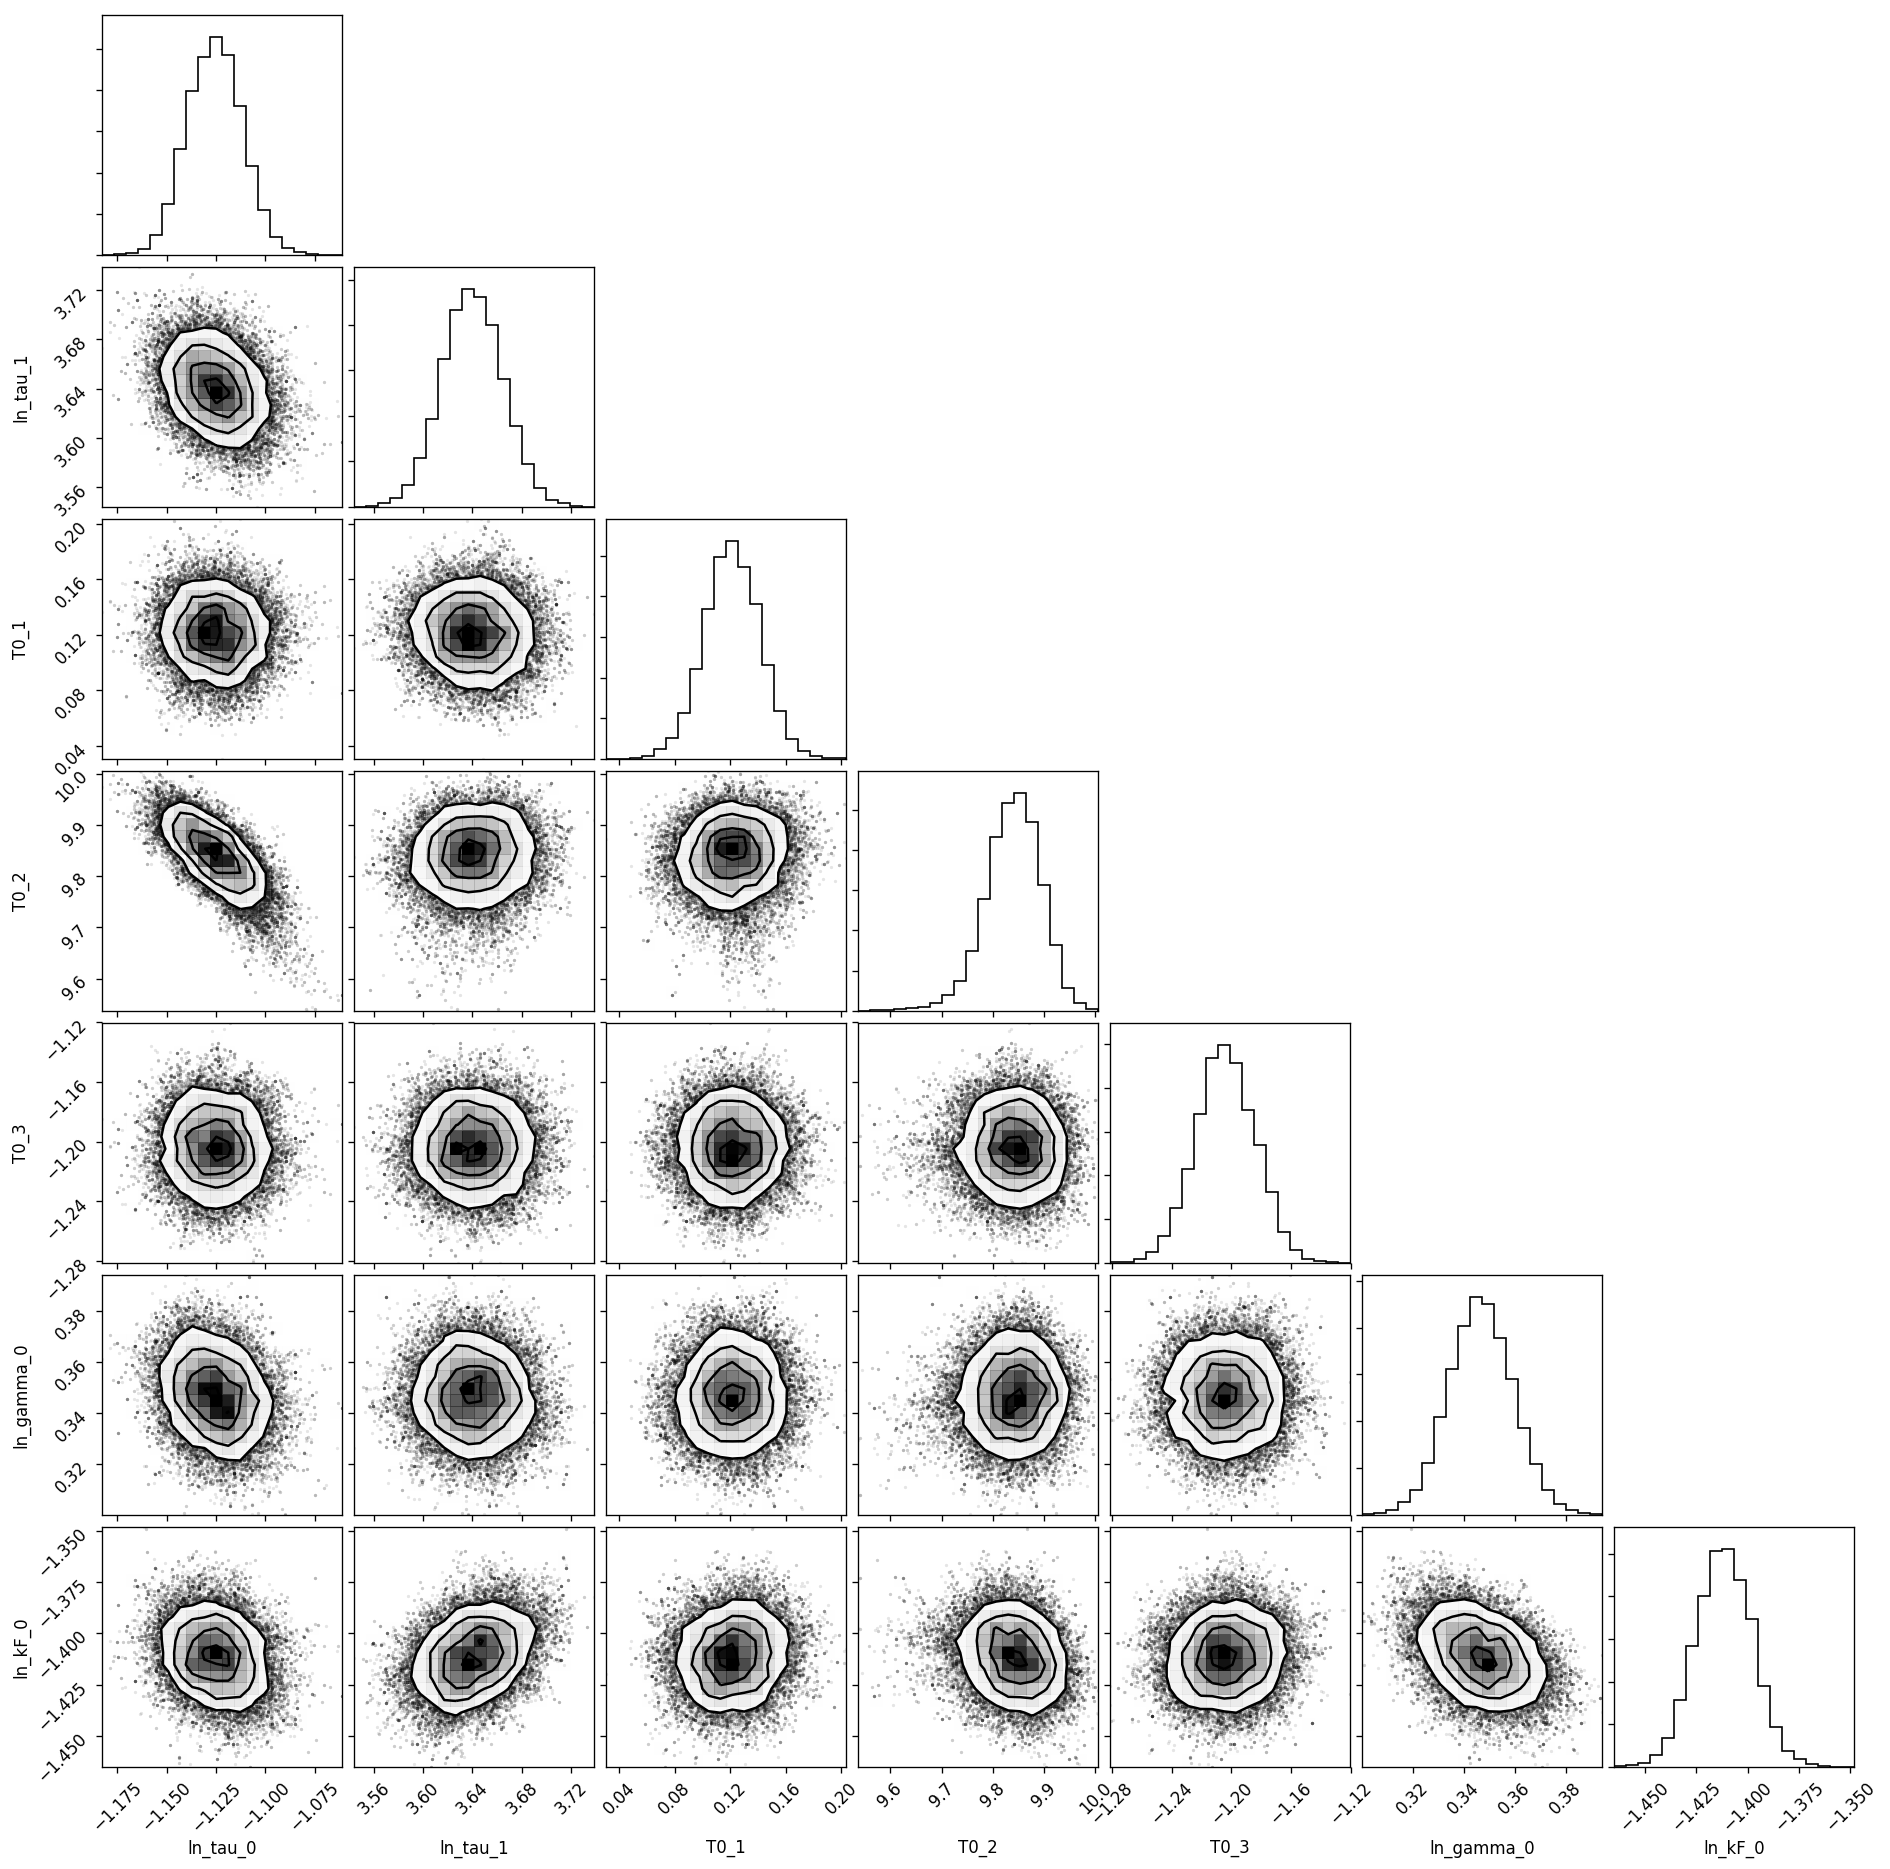

In [69]:
new_sampler.plot_corner(cube=False)

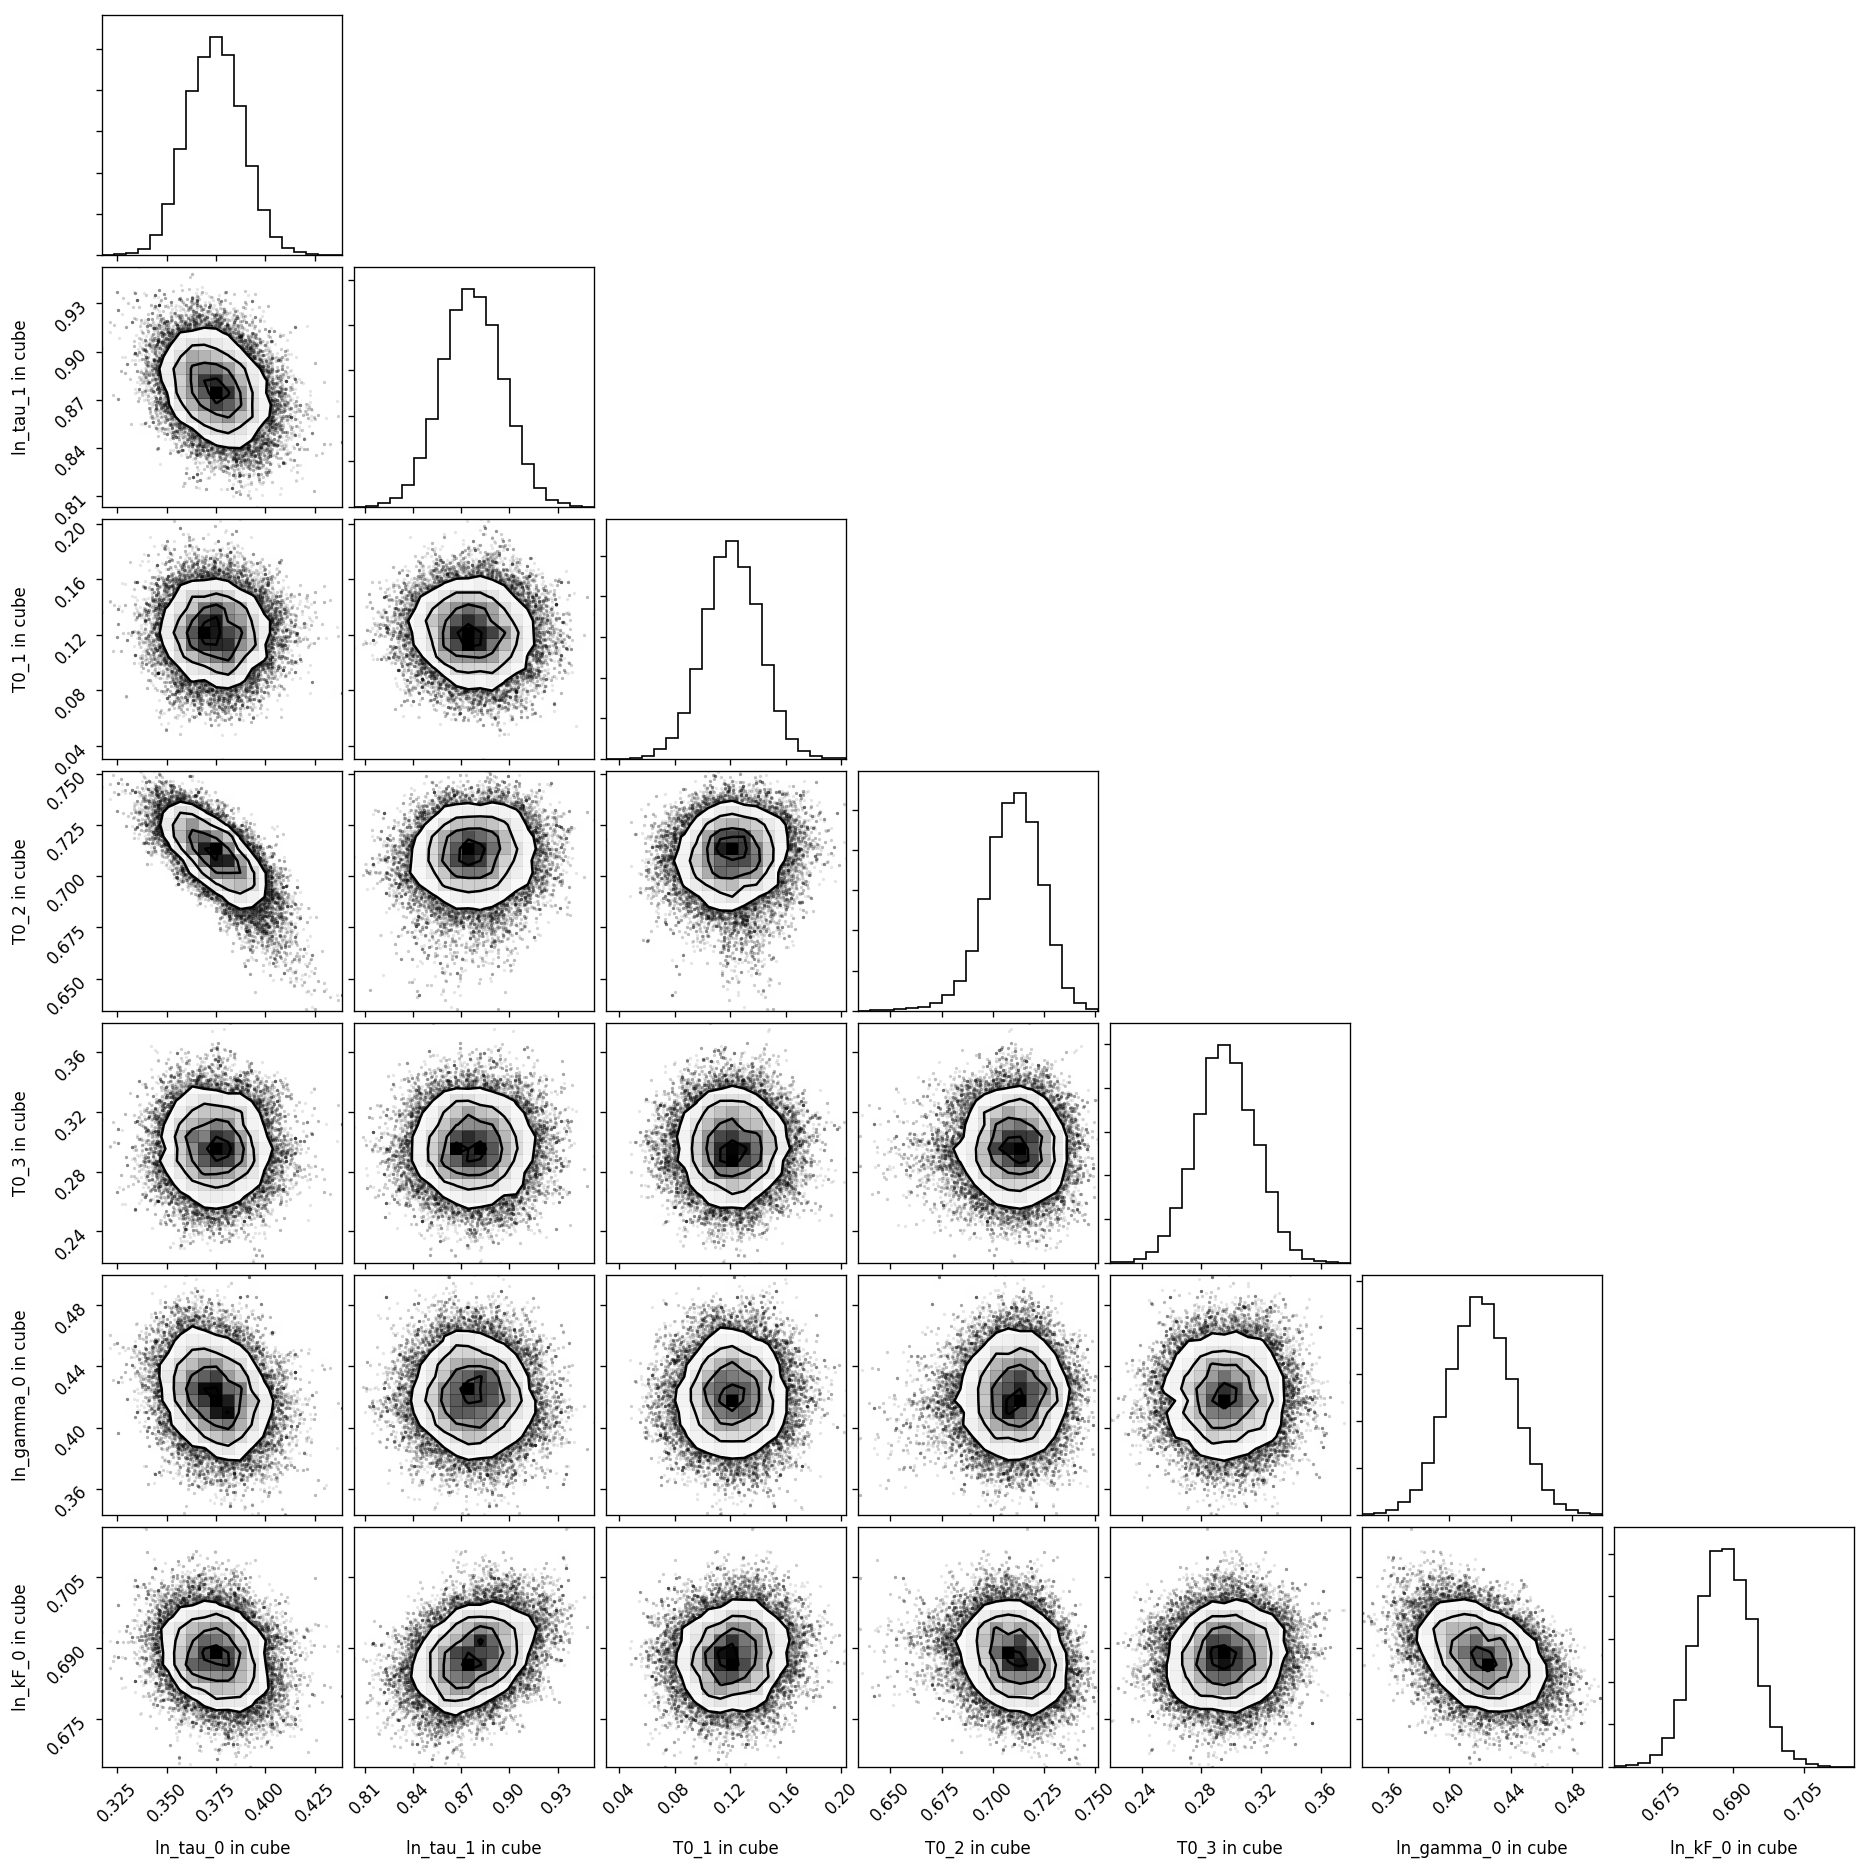

In [70]:
new_sampler.plot_corner(cube=True)

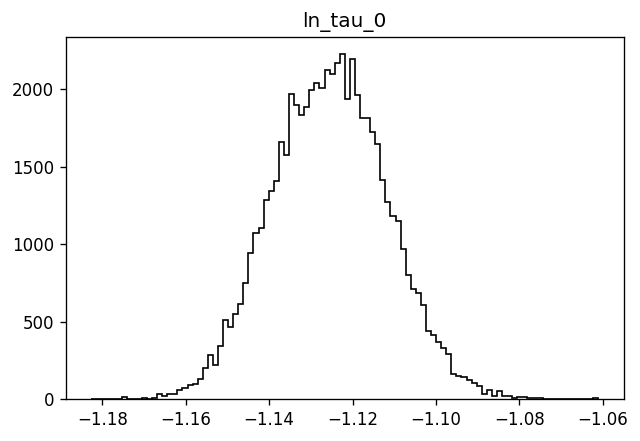

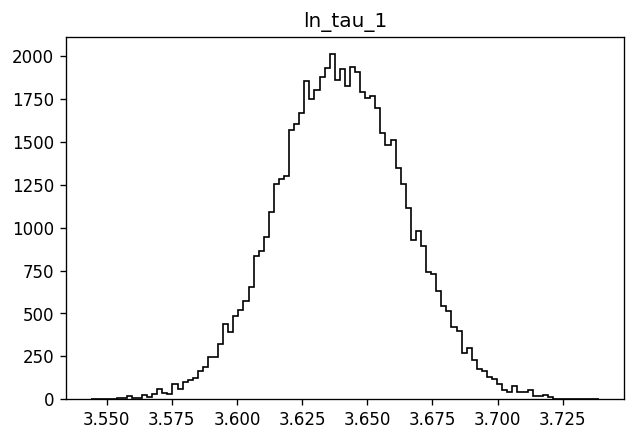

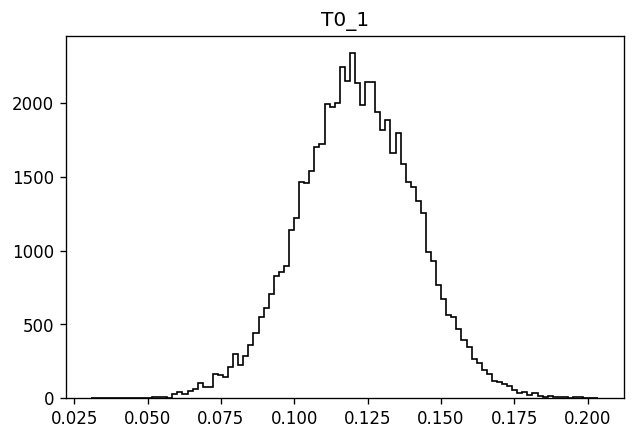

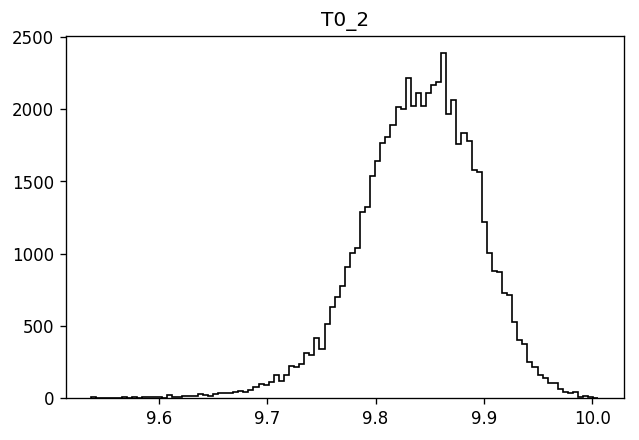

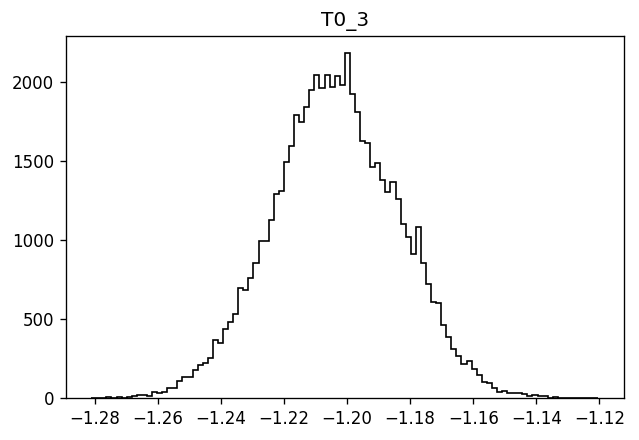

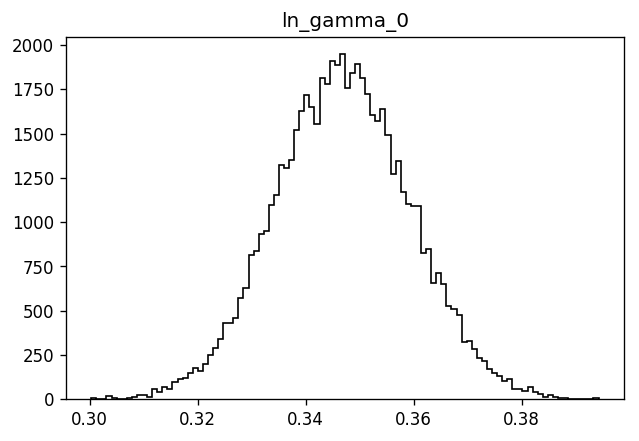

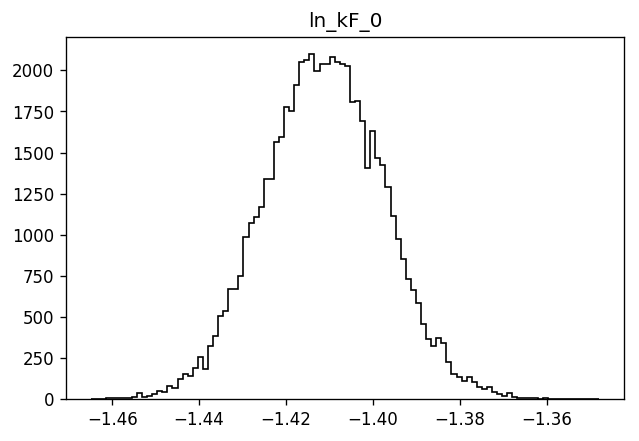

In [71]:
new_sampler.plot_histograms(cube=False)